<a href="https://colab.research.google.com/github/lapidesd/wetted_channels_from_space/blob/main/Colab_notebooks/mu_gradients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import math
import matplotlib.ticker as ticker
import matplotlib
%config InlineBackend.figure_format='retina'
from google.colab import files
from shapely.geometry import Point
from numpy import random
from scipy.spatial import distance

In [2]:
!pip install -q geopandas
!pip install -q gdown
import geopandas as gp
import gdown

     |████████████████████████████████| 1.0 MB 7.0 MB/s 
     |████████████████████████████████| 6.3 MB 46.8 MB/s 
     |████████████████████████████████| 16.7 MB 43.1 MB/s 


# Load runoff data

In [3]:
id = '1_wasEy1N5Nkq7_vBukG5_pnLS-4Dq8Ch'
url = 'https://drive.google.com/uc?id=%s'%id
output = 'level4e.csv'
gdown.download(url, output, quiet=False)
level4e = pd.read_csv(output,parse_dates=True,index_col=0)
dry_runoff = level4e['dryRunoff_mmDay^-1']
dry_runoff = dry_runoff.resample('1D').mean()

Downloading...
From: https://drive.google.com/uc?id=1_wasEy1N5Nkq7_vBukG5_pnLS-4Dq8Ch
To: /content/level4e.csv
100%|██████████| 92.2M/92.2M [00:00<00:00, 97.3MB/s]


# Load random forest predictions and geospatial data

In [4]:
# flow capacity predictions
id = '1BBe4XY3hY7WgjkG9pDkaeUkGqxuTtQRU'
url = 'https://drive.google.com/uc?id=%s'%id
output = 'mu_predictions.csv'
gdown.download(url, output, quiet=False)
temp = pd.read_csv(output)
temp.loc[temp.mu<=0,'mu'] = np.nan
temp.loc[temp.mu>90,'mu'] = np.nan

# geomorphic channel point locations
id = '148fowPhGXmm5ReUq5vEl9RB4U81j8uqB'
url = 'https://drive.google.com/uc?id=%s'%id
output = 'geomorph_pts.csv'
gdown.download(url, output, quiet=False)

# merge dataframes
g2 = pd.read_csv(output)
g2 = g2[['area_updated','x','y','ARCID','TO_NODE','FROM_NODE','Length']]
g2.x = g2.x.astype(float)
g2.y = g2.y.astype(float)
g2.ARCID = g2.ARCID.astype(float)
g2.area_updated = pd.to_numeric(g2.area_updated,errors='coerce')
df = g2.merge(temp,on=['x','y'])
df['id'] = range(len(df))

Downloading...
From: https://drive.google.com/uc?id=1BBe4XY3hY7WgjkG9pDkaeUkGqxuTtQRU
To: /content/mu_predictions.csv
100%|██████████| 424k/424k [00:00<00:00, 47.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=148fowPhGXmm5ReUq5vEl9RB4U81j8uqB
To: /content/geomorph_pts.csv
100%|██████████| 4.55M/4.55M [00:00<00:00, 94.0MB/s]


# Calculate contributing areas for each 10 m reach, identify downstream direction and calculate flow capacity gradients

In [5]:
# utm coordinates
x = df.x.values
y = df.y.values
pts = [Point(x[i],y[i]) for i in range(len(x))]
gdf = gp.GeoDataFrame(df,geometry=pts,crs='EPSG:4326')
gdf = gdf.to_crs('EPSG:26910')
xm = [item.x for item in gdf.geometry.values]
ym = [item.y for item in gdf.geometry.values]
df['xm'] = xm
df['ym'] = ym

def closest_node(node, nodes):
  closest_index = distance.cdist([node], nodes).argmin()
  return closest_index

# find the closest downstream point for each point
pts = np.vstack([df.xm.values,df.ym.values]).T
areas = df.area_updated.values
ids = df.id.values
sortidx = np.argsort(areas)
areas = areas[sortidx]
pts = pts[sortidx,:]
old_ids = ids[sortidx]
ids = ids[sortidx]
closest_ids = []
for i in range(np.shape(pts)[0]-1):
  some_pt = pts[0,:]
  pts = pts[1:,:]
  ids = ids[1:]
  closest_id = ids[closest_node(some_pt,pts)]
  closest_ids.append(closest_id)
closest_ids.append(closest_ids[-1])
closest_ids = np.array(closest_ids)
unsort = np.argsort(old_ids)
closest_ids = closest_ids[unsort]
df['closest_id'] = closest_ids

# calculate mu gradients and contributing areas
grads = []
dAs = []
for i,row in df.iterrows():
  mu2 = df.loc[df.id==row.closest_id].mu.values[0]
  mu1 = row.mu
  a2 = df.loc[df.id==row.closest_id].area_updated.values[0]
  a1 = row.area_updated

  #mm/day per 10 m
  ddx_mu = (mu2 - mu1)

  # m/s per 10 m
  ddx_mu = ddx_mu*1.15741e-8

  # m^3/s per m
  ddx_mu = ddx_mu*row.area_updated/10.0
  grads.append(ddx_mu)
  dA = a2 - a1
  dAs.append(dA)

df['ddx_mu'] = grads
df['dA'] = dAs

# Across a range of flow values, use flow capacity gradients to estimate hyporheic exchange fluxes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Use the colorbar set_ticks() method instead.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

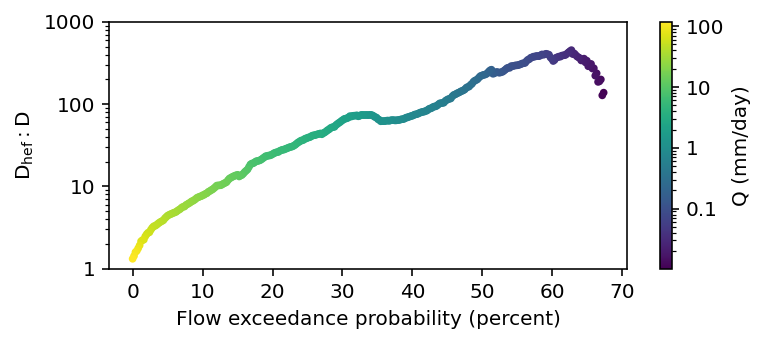

In [7]:
# flows and exceedances
numpts = 500
percs = np.array([np.quantile(dry_runoff,i/100.0) for i in np.linspace(0,100,numpts)])
exc = 100 - np.linspace(0,100,numpts)
idx = percs >= 0.01
percs = percs[idx]
exc = exc[idx]

# plot Qhef:Q for range of Q
f,ax = plt.subplots(figsize=(5.5,2.5))
area = df.area_updated.max()/1000000.0
temp = df.loc[df.area_updated<area*1000000]
qhefs = []
for runoff in percs:
  tempdf = temp.loc[temp.mu<runoff]
  exfil = np.abs(tempdf.loc[tempdf.ddx_mu<0].ddx_mu.mean())*len(tempdf.loc[tempdf.ddx_mu<0])*10
  # volumetric groundwater 
  qvol = runoff*1.15741e-8*tempdf.dA
  infil = tempdf.loc[tempdf.ddx_mu>0].ddx_mu*10 - qvol
  infil = infil.loc[infil>0]
  infil = infil.mean()*len(infil)
  qhef = (exfil+infil)/2.0
  qhefs.append(qhef)

qhefs = np.array(qhefs)
runoffs_volumetric =  percs*1.15741e-8*temp.area_updated.max()
ratios = qhefs/runoffs_volumetric
ratios[ratios==0] = np.nan
sc = ax.scatter(exc,ratios,c=percs,s=8,norm=matplotlib.colors.LogNorm())
cb = f.colorbar(sc)
ax.set_ylabel(r'$\mathrm{D_{hef}:D}$')
ax.set_xlabel('Flow exceedance probability (percent)')
ax.set_yscale('log')
ax.set_ylim(1,1000)

cb.set_label('Q (mm/day)')
from matplotlib.ticker import StrMethodFormatter, NullFormatter
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
ax.yaxis.set_minor_formatter(NullFormatter())

cb.ax.set_yticks([0.1,1,10,100])
cb.ax.set_yticklabels(['0.1','1','10','100'],fontsize = 10)

f.tight_layout()
f.savefig('./Dhef.png',dpi=300)
files.download('./Dhef.png')

# Create frames for wetted extent video with decreasing Q

In [36]:
# store frames here
!rm -r wetted_map
!mkdir wetted_map

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

Q = np.logspace(-2,1,100,base=10)
Q = np.flipud(Q)
counter = 0

cmap = plt.cm.plasma#_r  # define the colormap
# define the bins and normalize
bounds = [0.01,0.03,0.1,0.3,1,3,10,]#20,30]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# for each Q, plot extent
for q in Q:
  wet = df.loc[df.mu<q].copy()
  dry = df.loc[df.mu>=q].copy()

  f,ax = plt.subplots(figsize=(7,4))
  dry['mu'] = -1
  ax.scatter(dry.x,dry.y,s=0,norm=norm,alpha=0)
  cb = ax.scatter(wet.x,wet.y,c=wet.mu,s=2,norm=norm,cmap=cmap,edgecolor = 'None')
  
  # ax.set_title(str(date))
  ax.xaxis.set_visible(False)
  ax.yaxis.set_visible(False)

  axins = inset_axes(ax, width=1.3, height=0.9, loc='lower left',
                    borderpad = 3.)
  n,bin,patches = axins.hist(df.mu,bins = np.logspace(-2,1.,20),fc='limegreen',ec='k',lw=0.5)
  for i,patch in enumerate(patches): 
    patch.set_fc(cmap(norm(bin[i])))

  top = np.max(n)
  axins.plot([q,q],[0,top],c='k',ls='--')

  if q>0.1:
    axins.text(q,top*1.1,'Q = %.1f mm/day'%q,fontsize=8,**{'backgroundcolor':'w'})
  else:
    axins.text(q,top*1.1,'Q = %.2f mm/day'%q,fontsize=8,**{'backgroundcolor':'w'})

  axins.set_xscale('log')
  
  axins.set_xlabel('Flow capacity [mm/d]')#,fontsize = 12)
  axins.spines['right'].set_visible(False)
  axins.spines['left'].set_visible(False)
  axins.spines['top'].set_visible(False)
  axins.set_yticks([])
  axins.set_xticks([0.01,0.1,1,10])
  axins.set_xticklabels(['0.01','0.1','1','10'],fontsize = 8)
  axins.patch.set_alpha(0.6)
  sns.despine(ax=ax,left=True,bottom=True)

  cbar = plt.colorbar(cb,ax=ax,shrink=0.8)
  cbar.set_label('[mm/day]')
  cbar.set_label('Hyporheic flow capacity [mm/day]')


  import numpy as np
  import matplotlib.pyplot as plt
  from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
  import matplotlib.font_manager as fm
  fontprops = fm.FontProperties(size=10)
  scalebar = AnchoredSizeBar(ax.transData,
                           0.0058*2, '1 km', 'lower right', 
                           pad=0.1,
                           sep=4,
                           color='black',
                           frameon=False,
                           size_vertical=.0002,
                           fontproperties=fontprops)
  ax.add_artist(scalebar)


  f.savefig('/content/wetted_map/%s.png'%str(counter),dpi=300)
  counter = counter + 1
  plt.close(f)


# Use ffmpeg to stitch frames together

In [37]:
%%bash
cd wetted_map
ffmpeg -framerate 5 -i %d.png -c:v libx264 -r 30 recession.mp4

ffmpeg version 3.4.11-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-li

# download video 

In [38]:
files.download('/content/wetted_map/recession.mp4')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>